ST6704 MidTerm - Luis Moros
=====

The data come from an online lending company.  There are 90,000 normal customers (TARGET = “Normal”) and 4,000 default customers (TARGET = “Default”). 
The goal of this assignment is “Estimate the loan defaulting risk for a given customer”.  The instructor will give a presentation to explain this assignment in class as well.
You need to complete this exam by complete the following five tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Defining function to:
- Transform dates 
- Loading and saving CSVs

In [2]:
def dropColumns(df,clmns):
    return df.drop(clmns, axis=1)

def transformDateToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                        df[clmn].apply(
                                        lambda x: str(int(x)) if not pd.isnull(x) else x\
                                      ))\
                            .astype('int64')//1e9
        return df
    
def transformTimeDeltaToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                            pd.to_timedelta(df['last_job_opendate'], unit='D') + pd.datetime(1960, 1, 1))\
                            .astype('int64')//1e9
        return df
    
def transformMonthYearToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                        df[clmn].apply(
                                       lambda x: str(int(x)*100 + 1) if not pd.isnull(x) else x 
                                      ))\
                            .astype('int64')//1e9
        return df    

def prepareDate(df):
        return df\
                .pipe(transformDateToEpoch, clmn='al_date1')\
                .pipe(transformDateToEpoch, clmn='al_date2')\
                .pipe(transformDateToEpoch, clmn='al_date3')\
                .pipe(transformDateToEpoch, clmn='al_date1_bank')\
                .pipe(transformDateToEpoch, clmn='al_date1_nbank')\
                .pipe(transformTimeDeltaToEpoch, clmn='last_job_opendate')\
                .pipe(transformMonthYearToEpoch, clmn='qmonth')\

def saveCsv(df,name):
        df.to_csv(path_or_buf=name, index=False)
        return df

def setEvent(df):
    df['event'] = df['TARGET'].apply(lambda x: 1 if x.lower()=='default' else 0)
    return df.drop('TARGET', axis=1)

- Load train.csv
- Drop exteranl id fields
- Transform date to epoch

In [89]:
df = \
    pd.read_csv('train.csv')\
       .pipe(dropColumns, clmns=['Unnamed: 0','uid'])\
       .pipe(prepareDate)

Define function to:
- Calculate percentat of missings per field
- Memoization

In [4]:
def getmissPcntDf(d):
    obs, _ = d.shape
    return pd.DataFrame(d.apply(lambda x: (sum(x.isnull().values)/obs)*100), columns=['pcnt'])

def memoize(f):
    memo = {}
    def helper(d):
        if d.shape[0] not in memo:            
            memo[d.shape[0]] = f(d)
        return memo[d.shape[0]]
    return helper

getmissPcntDf = memoize(getmissPcntDf)

TASK #1: (50 Points)
====
There are large amount of missing values and there are significant amount of information in them.   Please utilize missing value information through (1) missing value indicator; (2) missing value pattern; and (3) smoothing missing value patterns.  After complete this task, report the following:
1.	All missing value indicators created and their relationship with the target variables.
2.	All missing value pattern variables created.

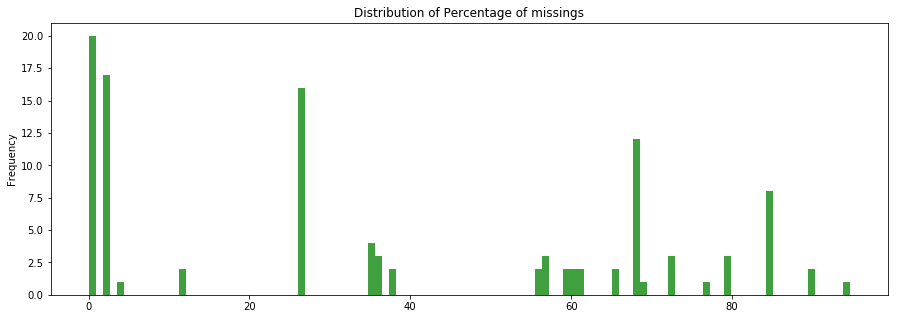

In [92]:
getmissPcntDf(df)['pcnt'].plot.hist(getmissPcntDf(df).shape[0], 
                                    facecolor='green', 
                                    alpha=0.75, 
                                    figsize=(15,5),
                                    title='Distribution of Percentage of missings');

Define functions to manage missings:
- Obtain column names with define missing percentages
- Define MVPs
- Apply mean imputation

In [93]:
from bitarray import bitarray
import struct

def namesOfColsWithMissingPcnt(df, lowerBound, upperBound):
    pcntDF = getmissPcntDf(df)
    return  pcntDF[(pcntDF['pcnt'] > lowerBound) & (pcntDF['pcnt'] < upperBound)].index
        
def getMissingPatern(x):
    b = bitarray(x, endian='little')
    b.invert()
    return b.to01()

def impCols(d):
    return namesOfColsWithMissingPcnt(d, 0.0, 5.0)

def meanImpCols(d): 
    return d.loc[:,impCols(d)].select_dtypes(include=['float64','int64']).columns

def indicatorImpCols(d):
    return d.loc[:,impCols(d)].select_dtypes(include=['object']).columns

def mvp1Cols(d):
    return namesOfColsWithMissingPcnt(d, 5.0, 40.0)

def mvp2Cols(d):
    return namesOfColsWithMissingPcnt(d, 40.0, 80.0)

def mvp3Cols(d):
    return namesOfColsWithMissingPcnt(d, 80.0, 100.0)

def preparedCols(d):
    return impCols(d).union(mvp1Cols(d).union(mvp2Cols(d).union(mvp3Cols(d))))
from sklearn.model_selection import train_test_split

def prepareMissings(src_df, dest_df ):
    return pd.DataFrame(dest_df.loc[:, meanImpCols(src_df)].apply(lambda x: x.fillna(x.mean()),axis=0))\
                .join(
                    pd.DataFrame(dest_df.loc[:, indicatorImpCols(src_df)].apply(lambda x: x.fillna('unknown'),axis=0))
                ).join(
                    pd.DataFrame(dest_df.loc[:,mvp1Cols(src_df)].apply(getMissingPatern,axis=1), columns=['mvp1'])
                ).join(
                    pd.DataFrame(dest_df.loc[:,mvp2Cols(src_df)].apply(getMissingPatern,axis=1), columns=['mvp2'])
                ).join(
                    pd.DataFrame(dest_df.loc[:,mvp3Cols(src_df)].apply(getMissingPatern,axis=1), columns=['mvp3'])
                ).join(
                    dest_df[dest_df.columns.difference(preparedCols(src_df))].select_dtypes(include=['object'])
                )                       

Manage missing values

In [98]:
prepared_df = prepareMissings(df, df)
prepared_df.loc[:,['mvp1','mvp2','mvp3']]

,mvp1,mvp2,mvp3
0,001110111111011100000000000,000000000000000000000000000000000,00000000000
1,000000111000011100000000000,001101100011000000000000000011000,00000000000
2,001110111111011100000001000,000000000000000000000000000000000,00000000000
3,001010111101000100000011111,000000000011000000000001100000000,00000000000
4,000000000000000000000001011,111101100011000000000000001111000,00000000000
5,000000000000000000000111101,000000000000000000000000000000000,00000000000
6,000000111000011100000001000,000000000000000110000110000000000,00000000000
7,001000111100011100000000000,010010000000000000000000000100000,00000000000
8,000000111000011100000000000,111010100000000000000000001110000,00000000000
9,000000111000011100000001001,000000000000000000000000000000000,00000000000


TASK #3: (30 Points)
===
Since there are significant number of categorical variables with high cardinality, to utilize a high cardinality categorical variable we can either perform smoothing or perform clustering.  Explain how you deal with this problem.

Define functions to:
- Apply smoothing

In [94]:
def smooth(x, p, sf,target):
    s = x.groupby([target]).size()
    n1 = s['Default'] if 'Default' in s.index else 0
    n0 = s['Normal'] if 'Normal' in s.index else 0

    return np.log(
                    (n1+(p*sf))/
                   (n0+((1.0-p)*sf))
                 )

def smoothField(d, p, field, target):    
    temp = pd.DataFrame(
                    d.groupby([field]).apply(
                                    lambda x: smooth(x,p,100,target)), 
                                columns=['smoothed_{0}'.format(field)])\
                .merge(d, left_index=True, right_on=field)
        
    d['smoothed_{0}'.format(field)] =  temp['smoothed_{0}'.format(field)]   
    #d.drop(field, axis=1, inplace=True)    

def smoothCategorical(d, target, exclude):
    t =d.groupby([target]).size()
    p = t['Default']/t['Normal'] 

    d.select_dtypes(include=['object'])\
        .columns\
        .difference(exclude)\
        .map(
                lambda field: smoothField(d, p, field, target)
        )
    return d

Apply smoothing

In [99]:
prepared_df = smoothCategorical(prepared_df, target='TARGET', exclude=['TARGET'])
prepared_df.loc[:,[col for col in prepared_df.columns if col.startswith('smoothed_')]]

,smoothed_GENDER,smoothed_H_PROV,smoothed_P_PROV,smoothed_cons_cont,smoothed_cons_max_m12_paycate,smoothed_cons_max_m3_paycate,smoothed_cons_time_recent,smoothed_mvp1,smoothed_mvp2,smoothed_mvp3
0,-3.642938,-3.241646,-3.331966,-4.064122,-3.935740,-3.986614,-3.874462,-4.869794,-3.622459,-3.452890
1,-2.749296,-3.241646,-2.966071,-3.489628,-3.951439,-3.879756,-3.874462,-5.016989,-4.200580,-3.452890
2,-3.642938,-3.319437,-3.358820,-3.685712,-3.462672,-3.395113,-3.874462,-4.422522,-3.622459,-3.452890
3,-3.642938,-4.023502,-3.094626,-4.064122,-4.049387,-4.204225,-3.874462,-3.098966,-3.581249,-3.452890
4,-3.642938,-2.912635,-3.096033,-4.064122,-3.442957,-3.464659,-3.874462,-3.731312,-3.651313,-3.452890
5,-2.749296,-3.383035,-3.432168,-3.489628,-3.951439,-3.879756,-3.874462,-3.210690,-3.622459,-3.452890
6,-3.642938,-2.904016,-3.029688,-4.064122,-4.046799,-3.467310,-3.874462,-5.637065,-4.800087,-3.452890
7,-2.749296,-3.092596,-3.096033,-3.489628,-3.935740,-3.986614,-3.874462,-4.811227,-1.509074,-3.452890
8,-3.642938,-2.904016,-3.029688,-3.489628,-3.951439,-3.879756,-3.874462,-5.016989,-2.450700,-3.452890
9,-3.642938,-4.023502,-4.327803,-3.685712,-3.462672,-3.395113,-3.874462,-5.202357,-3.622459,-3.452890


TAKS #2: (20 Points)
===
Suppose we define an outlier as any value which is bigger than mean plus 5 standard deviation, for each numerical variable report the percentage of outliers.  Also, explain how do you use deal with these outliers.


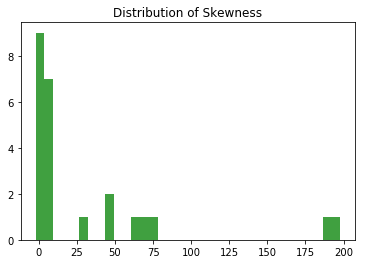

In [103]:
plt.hist(prepared_df.skew(axis=0, 
                          skipna=True, 
                          numeric_only=True),
         bins=prepared_df.shape[1], 
         facecolor='green', 
         alpha=0.75)
plt.title('Distribution of Skewness');

In [9]:
prepared_df.skew(axis=0, skipna=True, numeric_only=True).sort_values()

smoothed_P_PROV                   -1.970602
smoothed_H_PROV                   -0.858698
smoothed_mvp1                     -0.343778
smoothed_GENDER                    0.030089
cons_tot_m12_v_catenum             0.368826
cons_tot_m3_v_catenum              0.556902
cons_tot_m12_p_catenum             0.803165
cons_tot_m3_p_catenum              1.124245
smoothed_mvp2                      1.251928
smoothed_cons_cont                 4.187422
smoothed_mvp3                      5.651566
smoothed_cons_max_m3_paycate       5.678826
smoothed_cons_max_m12_paycate      5.946099
smoothed_cons_time_recent          6.328399
cons_tot_m3_visits                 6.654962
cons_tot_m12_visits                8.904014
cons_tot_m12_pay                  27.635559
cons_tot_m3_num                   43.894320
cons_max_m12_pay                  46.518661
cons_tot_m3_pay                   62.380175
cons_max_m3_pay                   71.806694
cons_max_m3_num                   76.661023
cons_tot_m12_num                

Define function to:
- Reduce skewness
- Eliminate outliers

In [104]:
def reduceSkewness(x):
    y = x
    skw = x.skew(axis=0, skipna=True)
    if skw < -0.5:
        y = x**2
        skw = y.skew(axis=0, skipna=True)
    if skw < -0.5:
        y = x**3
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = (x + np.abs(np.min(x)))**0.5
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = np.log(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True)  
    if skw > 0.5:   
        y = np.sqrt(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = 1/(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True)         
    if abs(skw) > 0.5:   
        y = x.rank()
        skw = y.skew(axis=0, skipna=True)  
    return y    

def eliminateOutliers(d,stds):
    return d[d.select_dtypes(exclude=['object']).apply(lambda x: np.abs(x - x.mean()) / x.std() <= stds).all(axis=1)]          

- Reduce Skewness
- Eliminate outliers
- Replace categorical 'TARGET' with numerical 'Event'

In [120]:
traning_df = prepared_df\
        .select_dtypes(['float64','int64'])\
        .apply(reduceSkewness)\
        .pipe(eliminateOutliers, stds=5)\
        .join(prepared_df.select_dtypes(exclude=['float64','int64']))\
        .pipe(setEvent)

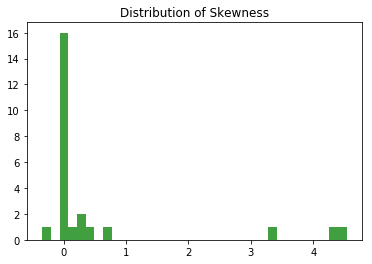

In [105]:
plt.hist(traning_df.skew(axis=0, skipna=True, numeric_only=True),bins=traning_df.shape[1], facecolor='green', alpha=0.75)
plt.title('Distribution of Skewness');

In [12]:
traning_df.skew(axis=0, skipna=True, numeric_only=True).sort_values()

smoothed_mvp1                   -0.343778
smoothed_P_PROV                 -0.010231
smoothed_mvp2                   -0.004636
cons_tot_m12_pay                -0.002879
cons_max_m12_pay                -0.000992
cons_tot_m12_visits              0.001911
cons_tot_m12_num                 0.002214
cons_tot_m3_pay                  0.002716
cons_max_m3_pay                  0.003119
cons_max_m12_num                 0.005085
cons_tot_m3_visits               0.006914
cons_tot_m3_num                  0.008279
smoothed_H_PROV                  0.008360
smoothed_cons_max_m12_paycate    0.009097
cons_max_m3_num                  0.014961
smoothed_cons_max_m3_paycate     0.017704
smoothed_GENDER                  0.030089
cons_tot_m12_p_catenum           0.193844
cons_tot_m3_v_catenum            0.313423
cons_tot_m3_p_catenum            0.339603
cons_tot_m12_v_catenum           0.368826
smoothed_cons_cont               0.753504
smoothed_mvp3                    3.356191
smoothed_cons_time_recent        4

TASK #4: (100 Points)  
======
After data preparation, build one or multiple models on the TARGET variable “TARGET”.

Define function to partition sets

In [107]:
from sklearn.model_selection import train_test_split

def getTrainPlusValidationSets(d):
    exclude_x = d.select_dtypes(include=['object']).columns.values.tolist()
    exclude_x.append('event')
    print(exclude_x)
    x = d.loc[:,d.columns.difference(exclude_x)] 
    y = d.loc[:,['event']]
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.3, random_state=1)
    return  x_train, x_validation, y_train.iloc[:,0].ravel(), y_validation.iloc[:,0].ravel() 

Partition train and validation sets

In [121]:
x_train, x_validation, y_train, y_validation = getTrainPlusValidationSets(traning_df);

['cons_cont', 'cons_time_recent', 'cons_max_m3_paycate', 'cons_max_m12_paycate', 'mvp1', 'mvp2', 'mvp3', 'GENDER', 'H_PROV', 'P_PROV', 'event']


Apply simple logistic regression

In [14]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)
logreg.score(x_train, y_train)

0.97490881458966561

Apply optimized logistic regression

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition  import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(22)
logistic_pca_model = make_pipeline(StandardScaler(),
                           PCA(n_components=10), 
                           linear_model.LogisticRegression())
param_grid = {'pca__n_components' : [10,15,20,24]}
best_logistic_pca = GridSearchCV(logistic_pca_model, param_grid, n_jobs=-1, cv=5)
best_logistic_pca.fit(x_train, y_train)
best_logistic_pca_score = cross_val_score(best_logistic_pca, x_train, y_train, cv=5).mean()
best_logistic_pca_score

0.97790270779618493

Apply simple gradient boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier


gradientBoosting = GradientBoostingClassifier(\
                                 n_estimators=100, 
                                 learning_rate=1.0,
                                 max_depth=1, 
                                 random_state=1)\
                    .fit(x_train, y_train)
    
gradientBoosting.score(x_train, y_train)  

0.98521276595744678

Apply optimized gradient boosting

In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition  import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(22)

param_grid = {
                'n_estimators': [50, 100, 150],
             }

best_gradientBosting_pca = GridSearchCV(
                                GradientBoostingClassifier(\
                                    n_estimators=100, 
                                    learning_rate=1.0,
                                    max_depth=1, 
                                    random_state=1), 
                                param_grid, 
                                cv=5,
                                n_jobs=-1)\
                            .fit(x_train, y_train)
best_gradientBosting_pca_score = cross_val_score(best_gradientBosting_pca, x_train, y_train, cv=5).mean()
best_gradientBosting_pca_score

0.98246216424437505

Apply Neural Networks

In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=1000, solver= 'adam', hidden_layer_sizes=(24,12,6), learning_rate_init= 0.1)
mlp.fit(x_train, y_train)
mlp.score(x_train, y_train)

0.95621580547112461

TASK #5: (50 Points)
====
Perform scoring on the scoring data set. (Scoring data set has 6,800 cases)

In [19]:
from sklearn import metrics

logistic_score = logreg.score(x_validation, y_validation)

logit_prediction = best_logistic_pca.predict(x_validation)
logistic_pca_score = metrics.accuracy_score(y_validation, logit_prediction)

gradientBoosting_prediction = gradientBoosting.predict(x_validation)
gb_score = metrics.accuracy_score(y_validation, gradientBoosting_prediction)

gradientBostting_prediction = best_gradientBosting_pca.predict(x_validation)
best_gb_score = metrics.accuracy_score(y_validation, gradientBostting_prediction)

mlp_prediction = mlp.predict(x_validation)
mlp_score = metrics.accuracy_score(y_validation, mlp_prediction)

result = pd.DataFrame([[logistic_score, logistic_pca_score, gb_score, best_gb_score, mlp_score]], 
             columns = ['logistic_score', 'logistic_pca_score', 'gb_score', 'best_gb_score', 'mlp_score'] )
result

,logistic_score,logistic_pca_score,gb_score,best_gb_score,mlp_score
0,0.977163,0.979716,0.985851,0.985922,0.960319


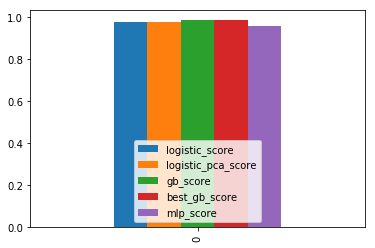

In [20]:
result.plot.bar(legend=False);
plt.legend(loc='lower center')

Load 'score.csv'

In [110]:
score_df = \
    pd.read_csv('score.csv')\
       .pipe(dropColumns, clmns=['Unnamed: 0','uid'])\
       .pipe(prepareDate)

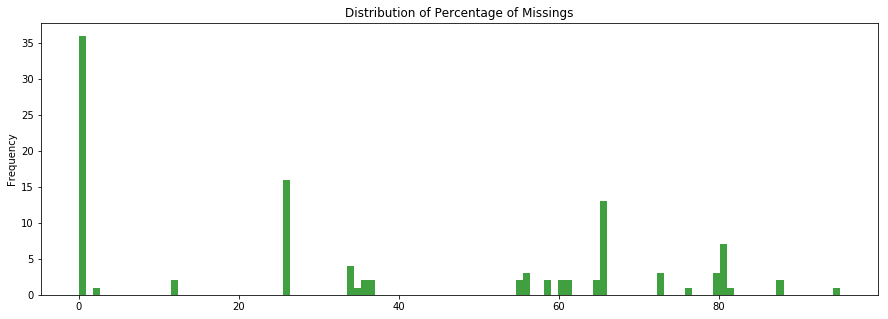

In [112]:
getmissPcntDf(score_df)['pcnt'].plot.hist(getmissPcntDf(score_df).shape[0],
                                          facecolor='green', 
                                          alpha=0.75, 
                                          figsize=(15,5),
                                          title='Distribution of Percentage of Missings');

Managing Missings in Score set

In [113]:
prepared_score_df = prepareMissings(df, score_df)

Lookup smoothed values in prepare dataframe

In [114]:
def lookup(field, src_df, dst_df ):
    dst_df['smoothed_{0}'.format(field.name)] =  dst_df.merge(\
                                                              src_df.loc[:,[
                                                                               'smoothed_{0}'.format(field.name), 
                                                                                field.name]
                                                                            ].drop_duplicates(keep='first'), 
                                                              on=field.name, 
                                                              how='left')\
                                                    ['smoothed_{0}'.format(field.name)]
    
    
prepared_score_df.select_dtypes(['object']).apply(lambda x: lookup(x, prepared_df, prepared_score_df))  

prepared_score_df.loc[:,[col for col in prepared_score_df.columns.values if col.startswith('smoothed_')]]

,smoothed_cons_cont,smoothed_cons_time_recent,smoothed_cons_max_m3_paycate,smoothed_cons_max_m12_paycate,smoothed_mvp1,smoothed_mvp2,smoothed_mvp3,smoothed_GENDER,smoothed_H_PROV,smoothed_P_PROV
0,-4.064122,-3.874462,-4.217902,-4.120231,-4.511024,-4.247735,-3.452890,-2.749296,-2.912635,-3.016151
1,-3.489628,-3.874462,-3.464659,-3.442957,-3.990488,-3.013911,-3.452890,-2.749296,-2.759002,-2.835121
2,-4.064122,-3.874462,-3.986614,-3.935740,-3.292126,-1.937909,-3.452890,-3.642938,-2.759002,-3.107314
3,-4.064122,-3.874462,-4.204225,-4.049387,-2.945513,-3.622459,-3.452890,-3.642938,-3.053857,-3.094626
4,-4.064122,-3.874462,-4.108596,-4.071718,-2.684136,-4.249005,-3.452890,-2.749296,-2.759002,-2.887837
5,-4.064122,-3.874462,-3.625743,-3.935740,-3.990488,-3.622459,-3.452890,-2.749296,-3.123529,-3.107314
6,-3.489628,-3.874462,-3.395113,-3.462672,-0.957239,-1.509074,-3.452890,-2.749296,-3.012226,-3.042642
7,-3.685712,-3.874462,-3.464659,-3.800138,-3.799339,-3.568123,-3.452890,-2.749296,-3.204459,-2.966071
8,-4.064122,-3.874462,-3.395113,-3.462672,-2.480401,-2.678566,-3.452890,-3.642938,-2.595733,-2.752573
9,-4.064122,-3.874462,-4.204225,-3.935740,-3.778897,-3.169514,-3.452890,-3.642938,-3.123529,-3.107314


Check percentage of missings after lookup

In [29]:
obs, _ = prepared_score_df.shape
prepared_score_df.apply(lambda x: (sum(x.isnull().values)/obs)*100)

cons_tot_m3_num                  0.000000
cons_tot_m3_pay                  0.000000
cons_tot_m3_p_catenum            0.000000
cons_tot_m3_v_catenum            0.000000
cons_tot_m3_visits               0.000000
cons_tot_m12_num                 0.000000
cons_tot_m12_pay                 0.000000
cons_tot_m12_p_catenum           0.000000
cons_tot_m12_v_catenum           0.000000
cons_tot_m12_visits              0.000000
cons_max_m3_num                  0.000000
cons_max_m3_pay                  0.000000
cons_max_m12_num                 0.000000
cons_max_m12_pay                 0.000000
cons_cont                        0.000000
cons_time_recent                 0.000000
cons_max_m3_paycate              0.000000
cons_max_m12_paycate             0.000000
mvp1                             0.000000
mvp2                             0.000000
mvp3                             0.000000
GENDER                           0.000000
H_PROV                           0.000000
P_PROV                           0

Applying mean imputing to looked-up fields as they present less than 5% of missing values 

In [115]:
prepared_score_df['smoothed_mvp1'] = prepared_score_df.loc[:,['smoothed_mvp1']].apply(lambda x: x.fillna(x.mean()))
prepared_score_df['smoothed_mvp2'] = prepared_score_df.loc[:,['smoothed_mvp2']].apply(lambda x: x.fillna(x.mean()))

Reduce skewness

In [ ]:
predict_df = prepared_score_df\
        .select_dtypes(['float64','int64'])\
        .apply(reduceSkewness)

Check distribution of skewness after reducing skewness

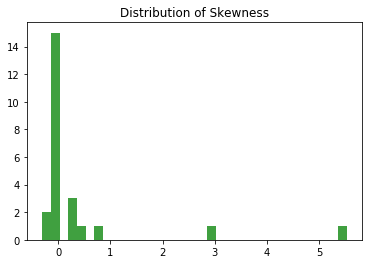

In [117]:
plt.hist(predict_df.skew(axis=0, 
                         skipna=True, 
                         numeric_only=True),
         bins=traning_df.shape[1], 
         facecolor='green', 
         alpha=0.75);
plt.title('Distribution of Skewness')

Predict based on score set and store results 

In [119]:
predictions = best_gradientBostting_pca.predict(predict_df)

score_df['TARGET'] = pd.Series(map(lambda x: 'Normal' if x == 0 else 'Default', predictions))

saveCsv(score_df,'lm_exam01_score_result.csv');